# Milestone 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from dateutil.relativedelta import relativedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

##### Extracting quotes from politicians

In [ ]:
df_reader = pd.read_json('quotes-2020-domains.json.bz2', lines=True, compression='bz2', chunksize=10000)

df_meta = pd.read_parquet('speaker_attributes.parquet')
df_meta = df_meta[df_meta['occupation'].notna()]
politicians = df_meta[df_meta.occupation.apply(lambda x: 'Q82955' in x)]
politicians = politicians[politicians['aliases'].notna()]
politicians = politicians[politicians['label'].notna()]
list_of_politicians = list(politicians.aliases.explode())
list_of_politicians += list(politicians.label)

df_politicians = pd.concat([
    chunk[chunk['speaker'].isin(list_of_politicians)]
    for chunk in df_reader])

##### Save to disk

In [ ]:
compression_opts = dict(method='zip',archive_name='politicians.csv')  
df_politicians.to_csv('politicians.zip', index=False, compression=compression_opts)
df_meta.to_csv('meta.zip', index=False, compression=compression_opts)

##### Read from disk

In [3]:
df_politicians = pd.read_csv("politicians.csv")
df_meta = pd.read_csv("meta.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Quote time correlation
# TODO
##### Using quotes as signal
##### TODO  We retrieve all of Joe Biden's and Donald Trump's quotes for the year 2020 and the associated dates. We create a signal for each politician corresponding to the number of speeches recorded each week of the year. And finally we can visualise the correlation of the two signals but also the time lag between the two signals

In [4]:
df_politicians.date = pd.to_datetime(df_politicians.date)

In [18]:
signal_Joe_Biden = np.zeros([53,]) # 53 weeks in 2020 because of leap year
signal_Donald_Trump = np.zeros([53,]) # 53 weeks in 2020 because of leap year
signal_macron = np.zeros([53,]) # 53 weeks in 2020 because of leap year


biden_aliases = list(df_meta[df_meta['label'] == 'Joe Biden']['aliases'].values[0]) # We extract different ways to call him in the df

chunk_Joe_Biden = df_politicians[(df_politicians.speaker == "Joe Biden") | (df_politicians.speaker.isin(biden_aliases))] # We extract all his quotes
weeks_Joe_Biden = chunk_Joe_Biden.date.apply(lambda x: x.week).values # We ectract all the weeks of eachs quotes
signal_Joe_Biden, _ = np.histogram(weeks_Joe_Biden, range(1, signal_Joe_Biden.shape[0]+2)) # We create an histogram of number of quotes per weeks

# Same for Trump
trump_aliases = list(df_meta[df_meta['label'] == 'Donald Trump']['aliases'].values[0])

chunk_Donald_Trump = df_politicians[(df_politicians.speaker == "Donald Trump") | (df_politicians.speaker.isin(trump_aliases))] 
weeks_Donald_Trump = chunk_Donald_Trump.date.apply(lambda x: x.week).values
signal_Donald_Trump, _ = np.histogram(weeks_Donald_Trump, range(1, signal_Donald_Trump.shape[0]+2))

# Same for another politician
macron_aliases = list(df_meta[df_meta['label'] == 'Emmanuel Macron']['aliases'].values[0])

chunk_macron = df_politicians[(df_politicians.speaker == "Emmanuel Macron") | (df_politicians.speaker.isin(macron_aliases))] 
weeks_macron = chunk_macron.date.apply(lambda x: x.week).values
signal_macron, _ = np.histogram(weeks_macron, range(1, signal_macron.shape[0]+2))

##### Plot the results

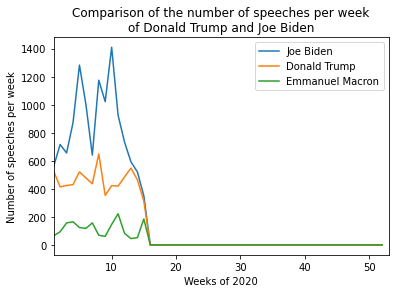

In [19]:
plt.plot(signal_Joe_Biden, label="Joe Biden")
plt.plot(signal_Donald_Trump, label="Donald Trump")
plt.plot(signal_macron, label="Emmanuel Macron")
plt.xlim(1,signal_Donald_Trump.shape[0])
plt.xlabel("Weeks of 2020")
plt.ylabel("Number of speeches per week")
plt.title("Comparison of the number of speeches per week\nof Donald Trump and Joe Biden")
plt.legend();

In [26]:
np.correlate(signal_Donald_Trump/signal_Donald_Trump.sum(), signal_Joe_Biden/signal_Joe_Biden.sum())[0] # We anaylse the correlation between signals, normalized

0.06468273151438089

In [27]:
np.correlate(signal_Donald_Trump/signal_Donald_Trump.sum(), signal_macron/signal_macron.sum())[0]

0.06119310265038908

# Quote similarity
### In this section we will demonstrate how we can compute quote similarity using Tfidf. This will be demonstrated using quotes from Donald Trump and Joe Biden.

##### Extract and save Trump and Biden quote 

In [8]:
chunk_Donald_Trump.to_csv("Trump_2020_v2")
chunk_Joe_Biden.to_csv("Biden_2020_v2")

##### Read the csv saved of Trump and Biden

In [9]:
Trump = pd.read_csv("Trump_2020_v2")
Biden = pd.read_csv("Biden_2020_v2")

##### Learn the vocabulary from the quotes of all politcians in the data set 

In [10]:
corpus = df_politicians['quotation'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=['english'])
vectorizer = vectorizer.fit(corpus)

###### Pick a random quote from Donald Trump

In [11]:
random = 25

In [12]:
ref_Trump = Trump.loc[random]
trump_quotes = [ref_Trump.quotation]

###### Extract quotes of Joe Biden within the following month after the quote by Donald Trump

In [13]:
Biden.date = pd.to_datetime(Biden.date)
Trump.date = pd.to_datetime(Trump.date)

In [14]:
ref_date = datetime.strptime(ref_Trump.date, '%Y-%m-%d %H:%M:%S')
end_date = ref_date + relativedelta(months=1)
Biden_target = Biden[Biden.date>ref_date]
Biden_target = Biden_target[Biden_target.date<end_date]
Biden_target = Biden_target[["date", "quotation"]].sort_values(ascending=True, by="date")

##### Vectorize the quotes using Tfidf

In [15]:
biden_quotes = Biden_target.quotation.to_list()

trump_vec = vectorizer.transform(trump_quotes)
biden_vec = vectorizer.transform(biden_quotes)

##### Rank the quotes of Joe Biden according to the cosine similarity to the quote by Donald Trump and select the most similar

In [16]:
similar_index = np.argmax(cosine_similarity(trump_vec, biden_vec))
print(cosine_similarity(trump_vec, biden_vec[similar_index]))
similar_quote = biden_quotes[similar_index]
print(trump_quotes)
print("-------")
print(biden_quotes[similar_index])

[[0.19533477]]
["In our discussions, Prime Minister Modi and I affirmed our two countries' commitment to protecting our citizens from radical Islamic terrorism. In this effort, the United States is also working productively with Pakistan to confront terrorists who operate on its soil."]
-------
It is important to get through this crisis, protecting our public health and our democracy,
